# 13 - 双重差分法

## 巴西南部的三块广告牌

记得我曾从事市场营销工作时，网络广告是一种极佳的手段。并非因其效率极高（尽管确实如此），而是因为它能轻易判断效果好坏。在线营销让你知晓哪些客户看到了广告，并通过 cookie 追踪他们是否最终访问了你的着陆页或点击了下载按钮。你还可以运用机器学习寻找与现有客户高度相似的潜在客户，仅向他们展示广告。从这个角度看，在线营销极为精准：你能精准定位目标人群，并清晰看到他们是否如预期般做出回应。

但并非所有人都易受网络营销的影响。有时，你不得不采用不那么精准的技术手段，比如电视广告或在街头竖立广告牌。通常，营销部门追求的是营销渠道的多样性。不过，如果将网络营销比作捕捉特定金枪鱼的专业钓竿，那么广告牌和电视广告则像是撒向鱼群的巨网，希望能至少捕获一些大鱼。广告牌和电视广告的另一个问题在于，其效果更难衡量。当然，你可以在某个地方投放广告牌前后，测量购买量或任何你想推动的指标。如果有所增长，就有证据表明营销是有效的。但你怎么知道这种增长不是产品认知度自然上升的趋势呢？换句话说，如果你一开始就没有设置广告牌，情况会如何发展——你如何知晓这一反事实 $Y_0$？

![img](./images/13/secrets.png)

解答此类问题的一种方法是双重差分法（Difference-in-Difference），简称 diff-in-diff。该方法常用于评估宏观干预措施的效果，例如移民对失业率的影响、枪支法律变更对犯罪率的影响，或是单纯衡量营销活动带来的用户参与度差异。这些案例中，干预前后各有一个时间段，研究者需要从总体趋势中剥离出干预措施的实际影响。以一个我亲身处理过的类似问题为例进行说明。

为评估广告牌作为营销渠道的效果，我们在南里奥格兰德州首府POA（阿雷格里港市）设置了 3 块广告牌，旨在观察此举是否能促进储蓄账户存款增长。需补充说明的是，对巴西地理不太熟悉的读者应注意：南里奥格兰德州位于该国南部，属于最发达地区之一。

考虑到这一点，我们决定同时分析来自南方另一座首府城市——圣卡塔琳娜州首府FL的数据。我们的设想是将FL作为对照组样本，用以估算与POA相比的反事实 $Y_0$ （需要说明的是，这并非真实的实验，真实实验数据保密，但思路非常相似）。我们在POA投放了整六月的广告牌，所获数据如下：

```{dropdown} 查看 Stata 代码
```stata
* Load data (assuming CSV is in current directory)
import delimited "./data/billboard_impact.csv", clear


list in 1/5

In [41]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


%matplotlib inline

style.use("fivethirtyeight")

In [43]:
data = pd.read_csv("data/billboard_impact.csv")
data.head()

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


需谨记，存款量是我们的结果变量，即我们希望通过广告牌提升的指标。POA 是POA（阿雷格里港市）的虚拟指示变量。当其值为零时，表示样本来自FL市。Jul 是代表七月或干预后时期的虚拟变量。当其值为零时，则指代五月这一干预前时期的样本。

## DID 估计量

为避免时间和处理变量混淆，下文将用 D 表示处理变量，T 表示时间变量。设 $Y_D(T)$ 为时期 T 下处理 D 的潜在结果。在能够观测反事实的理想情况下，我们将通过以下方式估算干预的处理效应：

$
\hat{ATET} = E[Y_1(1) - Y_0(1)|D=1]
$

换言之，因果效应是干预后时期接受处理的结果减去同期未接受处理的结果。当然，由于 $Y_0(1)$ 属于反事实范畴，我们无法实际测量这一效应。

一种解决方法是进行前后对比分析。

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(0)|D=1]
$

在我们的例子中，我们将比较 POA 在广告牌设置前后的平均存款额。

```{dropdown} 查看 Stata 代码
```stata
* 用处理组处理前作为反事实结果
* Calculate mean deposits for POA group before event (jul==0)
quietly summarize deposits if poa == 1 & jul == 0
local poa_before = r(mean)

* Calculate mean deposits for POA group after event (jul==1)
quietly summarize deposits if poa == 1 & jul == 1
local poa_after = r(mean)

* Calculate the difference
local diff = `poa_after' - `poa_before'

* Display results
display "POA Before: " `poa_before'
display "POA After: " `poa_after'
display "Difference (After - Before): " `diff'

In [46]:
poa_before = data.query("poa==1 & jul==0")["deposits"].mean()

poa_after = data.query("poa==1 & jul==1")["deposits"].mean()

poa_after - poa_before

41.04775

该估计值表明，干预后存款预计会增加 41.04 雷亚尔。但我们能相信这一结果吗？

注意到 $E[Y(0)|D=1]=E[Y_0(0)|D=1]$，即处理单元在干预前的观测结果与其反事实结果相同。由于我们正利用这一点来估计干预后的反事实结果 $E[Y_0(1)|D=1]$，上述估计隐含了 $E[Y_0(1)|D=1] = E[Y_0(0)|D=1]$ 的假设。

它指出，在没有干预的情况下，后期的结果将与起始时期的结果相同。如果结果变量遵循任何趋势，这一说法显然不成立。例如，假设存款在 POA 中呈上升趋势，$E[Y_0(1)|D=1] > E[Y_0(0)|D=1]$，这意味着即使没有干预，后期的结果也会大于起始时期的结果。同理，若 Y 呈下降趋势，$E[Y_0(1)|D=1] < E[Y_0(0)|D=1]$。这表明这种前后对比的方法并非一个良好的估计量。

另一个想法是将处理组与未接受干预的未处理组进行比较：

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(1)|D=0]
$

在我们的例子中，就是要比较干预后POA与FL的存款情况。

```{dropdown} 查看 Stata 代码
```stata
* 用控制组处理后作为反事实结果
* Calculate mean deposits for FL group after event (jul==1)
quietly summarize deposits if poa == 0 & jul == 1
local fl_after = r(mean)

* Calculate mean deposits for POA group after event (jul==1)
quietly summarize deposits if poa == 1 & jul == 1
local poa_after = r(mean)

* Calculate the difference
local diff = `poa_after' - `fl_after'

* Display results
display "FL After: " `fl_after'
display "POA After: " `poa_after'
display "Difference (After - Before): " `diff'


In [49]:
fl_after = data.query("poa==0 & jul==1")["deposits"].mean()
poa_after - fl_after

-119.10175000000001

该估计量告诉我们，营销活动产生了负面影响，客户存款将减少 119.10 雷亚尔。

注意 $E[Y(1)|D=0]=E[Y_0(1)|D=0]$。由于我们使用 $E[Y(1)|D=0]$ 来估算干预后处理组的反事实情况，我们假设可以这样替代缺失的反事实：$E[Y_0(1)|D=0] = E[Y_0(1)|D=1]$。但需注意，这仅在两组基线水平极为相似时才成立。例如，若FL的存款远多于POA，此假设便不成立，因为 $E[Y_0(1)|D=0] > E[Y_0(1)|D=1]$。反之，若FL的存款水平较低，则会有 $E[Y_0(1)|D=0] < E[Y_0(1)|D=1]$。

重申一次，这不是个好主意。为解决此问题，我们可以结合空间与时间比较。这就是双重差分法的核心思想，其通过以下方式替代缺失的反事实：

$
E[Y_0(1)|D=1] = E[Y_0(0)|D=1] + (E[Y_0(1)|D=0] - E[Y_0(0)|D=0])
$

这个方法的做法是：取处理组在干预前的观测值，并加上一个趋势项，而这个趋势是通过对照组估计出来的，即：$E[Y_0(1)|D=0] - E[Y_0(0)|D=0]$。换句话说，它的含义是：
若处理组在干预后没有接受干预，它的表现将会像是“干预前的自己”再加上一个“与对照组增长趋势相同的增长因子”。

需注意的是，这一方法假设处理组与对照组的趋势相同：

$
E[Y_0(1) − Y_0(0)|D=1] = E[Y_0(1) − Y_0(0)|D=0]
$

其中左侧为反事实趋势。现在，我们可以在处理效应定义中替换估计的反事实 $E[Y_1(1)|D=1] - E[Y_0(1)|D=1]$

$
\hat{ATET} = E[Y(1)|D=1] - (E[Y(0)|D=1] + (E[Y(1)|D=0] - E[Y(0)|D=0])
$

若重新排列各项，即可得到经典的双重差分估计量。

$
\hat{ATET} = (E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0])
$

之所以得此名，是因为它捕捉的是处理前后处理组与对照组之间差异的差值。

以下是其在代码中的表现形式。

```{dropdown} 查看 Stata 代码
```stata
* DID
* Calculate mean deposits for POA group before event (jul==0)
quietly summarize deposits if poa == 1 & jul == 0
local poa_before = r(mean)

* Calculate mean deposits for POA group after event (jul==1)
quietly summarize deposits if poa == 1 & jul == 1
local poa_after = r(mean)

* Calculate mean deposits for FL group before event (jul==0)
quietly summarize deposits if poa == 0 & jul == 0
local fl_before = r(mean)

* Calculate mean deposits for FL group after event (jul==1)
quietly summarize deposits if poa == 0 & jul == 1
local fl_after = r(mean)

* Calculate the difference in difference
local did = (`poa_after' - `poa_before') - (`fl_after' - `fl_before')


* Display results
display "FL trends: " `fl_after' - `fl_before'
display "POA trends: " `poa_after' - `poa_before'
display "Difference in difference: " `did'

In [52]:
fl_before = data.query("poa==0 & jul==0")["deposits"].mean()

diff_in_diff = (poa_after-poa_before)-(fl_after-fl_before)
diff_in_diff

6.524557692307688

双重差分法告诉我们，预计每位客户的存款将增加 6.52 雷亚尔。值得注意的是，双重差分法所做的假设比另外两种估计量更为合理。它仅假设两座城市的增长模式相同，既不要求它们具有相同的基准水平，也不要求增长趋势为零。

为了直观展示双重差分法的作用，我们可以将未处理组的增长趋势投射到处理组中，以观察反事实——即在没有干预的情况下，我们预期会看到的存款数量。

```{dropdown} 查看 Stata 代码
```stata
clear
input period str3 month fl_values poa_values counterfactual
1 "May" 171.642308 46.016 46.016
2 "Jul" 206.1655 87.06375 80.539192
end

* Create the plot with proper legend labeling
twoway ///
    (connected fl_values period, lwidth(2) lcolor(blue) mcolor(blue)) ///
    (connected poa_values period, lwidth(2) lcolor(red) mcolor(red)) ///
    (line counterfactual period, lwidth(2) lcolor(green) lpattern(dash)), ///
    xlabel(1 "May" 2 "Jul") ///
    xtitle("Month") ytitle("Deposits") ///
    title("Deposit Trends Comparison") ///
    legend(order(1 "FL" 2 "POA" 3 "Counterfactual") position(6) rows(1)) ///
    graphregion(color(white)) plotregion(color(white))

* diff_plot: A Stata Module to Visualize Two-Period, Two-Group Difference-In-Differences
* ssc install elabel, replace //installing elabel 
* ssc install diff_plot //installing diff_plot


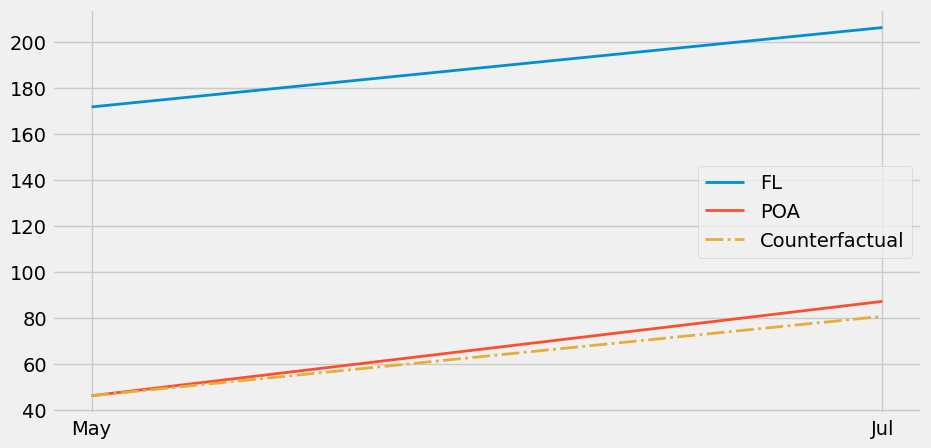

In [55]:
plt.figure(figsize=(10,5))
plt.plot(["May", "Jul"], [fl_before, fl_after], label="FL", lw=2)
plt.plot(["May", "Jul"], [poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend()
plt.show() ;

注意到红色与黄色虚线之间的细微差别了吗？若仔细观察，你会发现POA存在微小的处理效应。

![img](./images/13/cant-read.png)


此刻你可能在自问：“我该多大程度上信任这个估计量？我有权要求查看标准误报告！”这合情合理，因为缺乏标准误的估计量显得不够严谨。为此，我们将运用一个巧妙的回归技巧。具体而言，我们将估计以下线性模型：

$
Y_i = \beta_0 + \beta_1 POA_i + \beta_2 Jul_i + \beta_3 POA_i*Jul_i + e_i
$

注意，$\beta_0$ 是控制的基线。在我们的案例中，即FL五月份的存款水平。若开启处理城市虚拟变量，则得到 $\beta_1$。因此，$\beta_0 + \beta_1$ 代表干预前五月POA的基线，而 $\beta_1$ 是在FL基础上POA的基线增量。关闭POA虚拟变量并开启七月虚拟变量时，得到 $\beta_0 + \beta_2$，即干预期后七月份FL的水平。$\beta_2$ 则是控制的趋势，因为我们在基线之上加上它以得到干预后时期的控制水平。简而言之，$\beta_1$ 是从控制组转向处理组时的增量，$\beta_2$ 是从干预前到干预后时期的增量。最后，若同时开启两个虚拟变量，则得到 $\beta_3$。$\beta_0 + \beta_1 + \beta_2 + \beta_3$是干预后POA的水平。因此，$\beta_3$ 是从五月到七月、从FL到波阿时的增量影响。换言之，这就是双重差分估计量。

若您对我的说法存疑，不妨亲自验证一番。您将得到与我们先前完全一致的结果数值，同时也会注意到我们如何获得了梦寐以求的标准误差。

```{dropdown} 查看 Stata 代码
```stata
* TWFE 
reg deposits i.poa##i.jul

In [58]:
smf.ols('deposits ~ poa*jul', data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755


## 非平行趋势

双重差分法（Diff-in-Diff）一个显而易见的问题是无法满足平行趋势假设。若处理组的增长趋势与对照组不同，双重差分估计将产生偏误。这在非随机数据中尤为常见，例如决定对某地区实施干预是基于其可能对干预反应良好的潜力，或是干预针对的是表现欠佳的地区。以我们的营销案例为例，我们选择在 POA 测试广告牌，并非为了检验广告牌的一般效果，而是因为该地区销售业绩不佳。或许线上营销在当地效果不彰。这种情况下，若未设置广告牌， POA 的增长可能低于其他城市的观测值，这将导致我们低估广告牌在该地的效果。

一种验证这种情况是否发生的方法是绘制过去时期的趋势图。例如，假设 POA 呈现小幅下降趋势，而 FL 则处于急剧上升阶段。此时，展示前期数据将揭示这些趋势，从而让我们明白双重差分法并非可靠的估计量。

```{dropdown} 查看 Stata 代码
```stata
* Non PT
* Create temporary dataset for plotting
clear
input period str3 month fl_values poa_values counterfactual
1 "Jan" 120 60 .
2 "Mar" 150 50 .
3 "May" 171.642308 46.016 46.016
4 "Jul" 206.1655 87.06375 80.539192
end

* Create the plot
twoway ///
    (connected fl_values period, lwidth(2) lcolor(blue) mcolor(blue)) ///
    (connected poa_values period, lwidth(2) lcolor(red) mcolor(red)) ///
    (line counterfactual period if period >= 3, lwidth(2) lcolor(green) lpattern(dash)), ///
    xline(3, lpattern(dash) lcolor(gs10) lwidth(1)) ///
	xlabel(1 "Jan" 2 "Mar" 3 "May" 4 "Jul", angle(45)) ///
    xtitle("") ytitle("Deposits") ///
    title("Deposit Trends Comparison", size(medium)) ///
    legend(order(1 "FL" 2 "POA" 3 "Counterfactual") position(6) rows(1)) ///
    graphregion(color(white)) plotregion(color(white)) ///
    scheme(s1color) ///
    xsize(10) ysize(5)  // Sets figure size to 10x5 inches

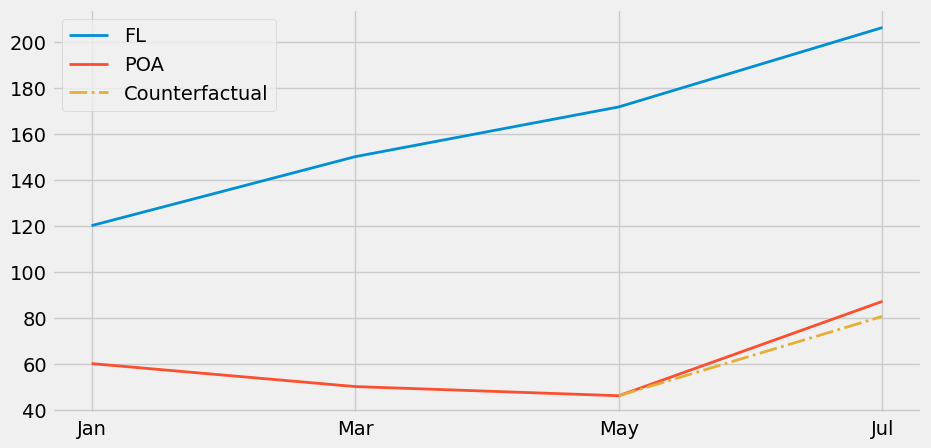

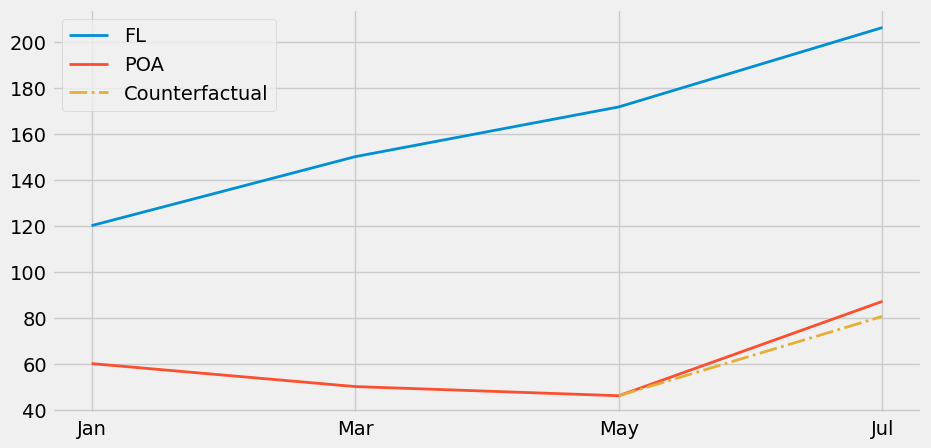

In [63]:
plt.figure(figsize=(10,5))
x = ["Jan", "Mar", "May", "Jul"]

plt.plot(x, [120, 150, fl_before,  fl_after], label="FL", lw=2)
plt.plot(x, [60, 50, poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)], label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend()
plt.show() ;

我们将探讨如何利用合成控制法解决这一问题。该方法通过整合多个城市的数据构建一个合成城市，使其趋势与目标城市高度吻合。但需谨记，在应用双重差分法时，必须始终验证平行趋势假设是否成立。

![img](./images/13/non-parallel.png)

最后值得指出的是，若仅有聚合数据，则无法为双重差分估计量构建置信区间。例如，当缺乏 FL 或 POA 每位客户的具体行为数据，仅掌握干预前后两城市存款均值时，虽仍可通过双重差分估计因果效应，但无法获知其方差。这是因为数据中的所有变异性在聚合过程中被完全消除。

## 核心要点

我们探讨了一种广泛应用于估计更宏观实体（如学校、城市、州、国家等）因果效应的技术——双重差分法。该方法通过比较处理单元在干预前后的结果趋势与控制单元的趋势差异，来评估处理效应。在此案例中，我们看到了如何利用这一方法来估计城市特定营销活动的效果。

最后，我们分析了当处理单元与控制单元的趋势不一致时，双重差分法为何会失效。同时，我们也了解到，若仅有聚合数据，双重差分法的应用将面临显著问题。




## 参考文献
我愿将这一系列作品视为对 Joshua Angrist、Alberto Abadie 和 Christopher Walters 杰出计量经济学课程的致敬。第一部分的大部分思想源自他们在美国经济学会授课的内容。在艰难的 2020 年，正是观看他们的课程视频让我保持了理智。

 - [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
 - [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

 我还想引用 Angrist 的精彩著作。它们向我展示了计量经济学（他们称之为“Metrics”）不仅极为实用，而且充满乐趣。
 - [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)
 - [Mastering ‘Metrics](https://www.masteringmetrics.com)

最后还要感谢 Miguel Hernán 和 Jamie Robins 的[《Causal Inference》](https://hsph.harvard.edu/profile/miguel-hernan/)一书。它是我在面对最棘手的因果问题时的可靠伙伴。

![img](./images/poetry.png)

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。